<a href="https://colab.research.google.com/github/LyesZ/object_detection_demo/blob/master/local_inference_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Run inference test
Test with images in repository `object_detection_demo/test` directory.

In [38]:
repo_url = 'https://github.com/LyesZ/object_detection_demo'

import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull



%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py



/content
Cloning into 'object_detection_demo'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 646 (delta 112), reused 131 (delta 110), pack-reused 511
Receiving objects: 100% (646/646), 127.44 MiB | 31.56 MiB/s, done.
Resolving deltas: 100% (172/172), done.
/content/object_detection_demo
Already up to date.
/content
/content/models/research
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_experimental_model
[       OK ] ModelBuilderTest.test_create_experimental_model
[ RUN      ]

In [41]:

%cd /content/object_detection_demo/model
%ls

/content/object_detection_demo/model
frozen_inference_graph.pb  ssd_mobilenet_v2_coco.config


In [42]:
import os
%cd /content
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/content/object_detection_demo/model/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/content/object_detection_demo/data/labelmap.pbtxt'

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR (./test).
PATH_TO_TEST_IMAGES_DIR = '/content/object_detection_demo/test'
a=os.listdir('/content/object_detection_demo/test')
print(a)
os.path.isfile(PATH_TO_CKPT)
os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

/content
['tomates-cerises-coupees.jpg', '25715300141470413018787.jpg', '15.jpg', '7158ba0052c2fa1c82cdb67411d67932.jpg', 'tableaux-sur-toile-tomate-coupee-en-forme-de-coeur.jpg']
['/content/object_detection_demo/test/tomates-cerises-coupees.jpg', '/content/object_detection_demo/test/25715300141470413018787.jpg', '/content/object_detection_demo/test/15.jpg', '/content/object_detection_demo/test/7158ba0052c2fa1c82cdb67411d67932.jpg', '/content/object_detection_demo/test/tableaux-sur-toile-tomate-coupee-en-forme-de-coeur.jpg']


/content/models/research/object_detection


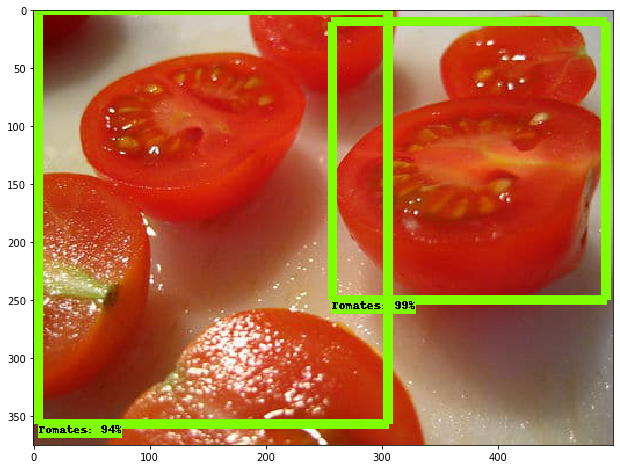

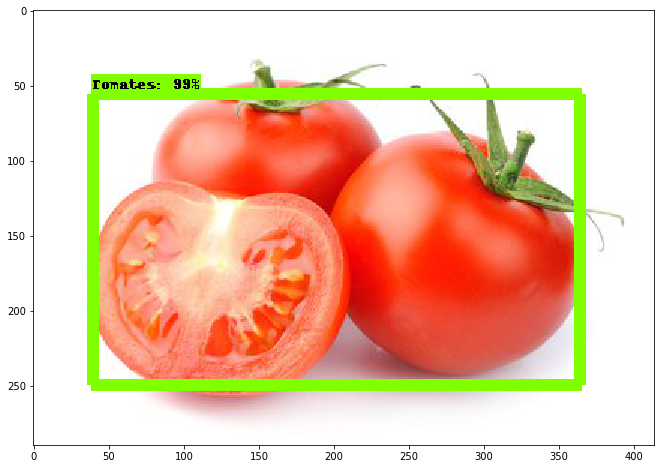

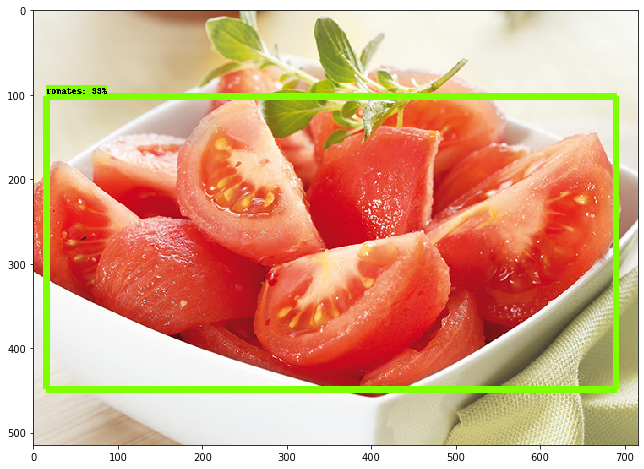

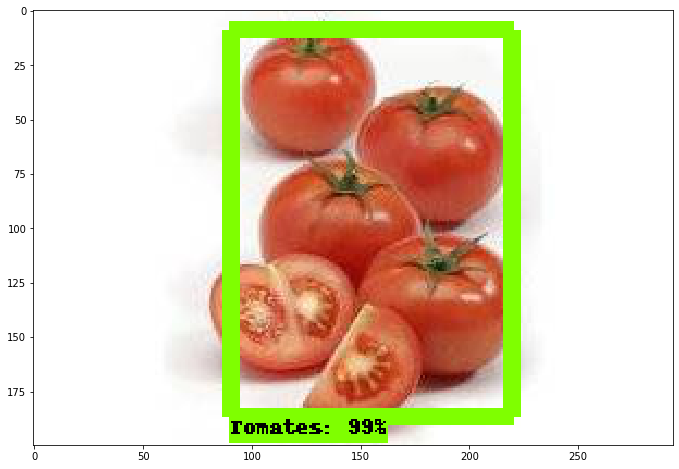

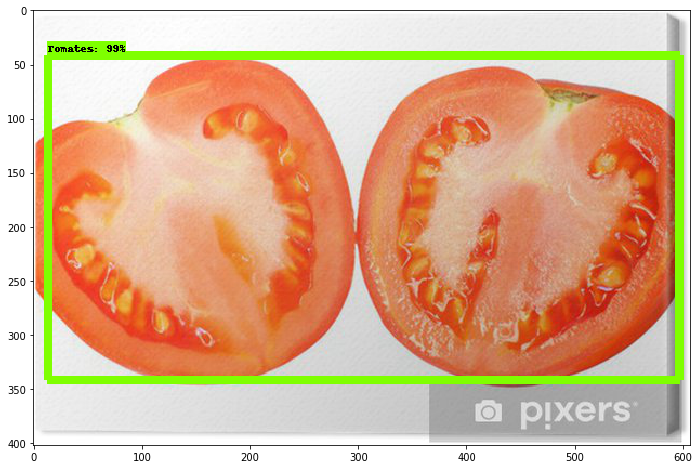

In [43]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

NUM_CLASSES = 1

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

### Benchmark TensorFlow inference speed

In [44]:
import time


def run_inference_benchmark(image, graph, trial=20, gpu=True):
    """Run TensorFlow inference benchmark.

    Arguments:
        image {np.array} -- Input image as an Numpy array.
        graph {tf.Graph} -- TensorFlow graph object.

    Keyword Arguments:
        trial {int} -- Number of inference to run for averaging. (default: {20})
        gpu {bool} -- Use Nvidia GPU when available. (default: {True})

    Returns:
        int -- Frame per seconds benchmark result.
    """

    with graph.as_default():
        if gpu:
            config = tf.ConfigProto()
        else:
            config = tf.ConfigProto(device_count={"GPU": 0})
        with tf.Session(config=config) as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                "num_detections",
                "detection_boxes",
                "detection_scores",
                "detection_classes",
                "detection_masks",
            ]:
                tensor_name = key + ":0"
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name
                    )
            if "detection_masks" in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict["detection_boxes"], [0])
                detection_masks = tf.squeeze(tensor_dict["detection_masks"], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict["num_detections"][0], tf.int32
                )
                detection_boxes = tf.slice(
                    detection_boxes, [0, 0], [real_num_detection, -1]
                )
                detection_masks = tf.slice(
                    detection_masks, [0, 0, 0], [real_num_detection, -1, -1]
                )
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1]
                )
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8
                )
                # Follow the convention by adding back the batch dimension
                tensor_dict["detection_masks"] = tf.expand_dims(
                    detection_masks_reframed, 0
                )
            image_tensor = tf.get_default_graph().get_tensor_by_name(
                "image_tensor:0"
            )

            # Run inference
            times = []
            # Kick start the first inference which takes longer and followings.
            output_dict = sess.run(
                tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)}
            )
            for i in range(trial):
                start_time = time.time()
                output_dict = sess.run(
                    tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)}
                )
                delta = time.time() - start_time
                times.append(delta)
            mean_delta = np.array(times).mean()
            fps = 1 / mean_delta
            print("average(sec):{:.3f},fps:{:.2f}".format(mean_delta, fps))

    return fps

image = Image.open(TEST_IMAGE_PATHS[-1])
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection benchmark.
fps = run_inference_benchmark(image_np, detection_graph, trial=20, gpu=False)

average(sec):0.074,fps:13.45
